In [ ]:
#if ibmdbp4ynps package is available in the object storage locally, first download it

In [1]:
from project_lib import Project
project = Project(project_id= '05d07336-a483-4286-99fe-8db076c2d8a9', project_access_token= 'p-ca0bec90883909bd2901585005ac052c7c369cf1')



def download_file(file_name):
    '''
    file_name = Name of zip file you want to download from object storage
    '''
    try:
        fobj = open(file_name, "wb")
        print(fobj)
        fobj.write(project.get_file(file_name).read()) 
        fobj.close()
        
    except Exception as e:
        print(Exception,e)
    else:
        print('Files downloaded successfully')
download_file('ibmdbpy4nps-0.2.1.7.tar.gz')

<_io.BufferedWriter name='ibmdbpy4nps-0.2.1.7.tar.gz'>
Files downloaded successfully


In [ ]:
#Install ibmdbp4nps if not installed already

In [2]:
pip install ibmdbpy4nps

/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/dhcrypto.py:16: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/secretstorage/util.py:25: CryptographyDeprecationWarning: int_from_bytes is deprecated, use int.from_bytes instead
  from cryptography.utils import int_from_bytes
     |████████████████████████████████| 164 kB 15.6 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
#connect to database table

In [3]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ibmdbpy4nps import IdaDataBase, IdaDataFrame
from ibmdbpy4nps.ae import NZFunTApply
from ibmdbpy4nps.ae import NZFunApply
from ibmdbpy4nps.ae import NZFunGroupedApply




dsn = "jdbc:netezza://169.63.46.17:5480/customer_churn"

idadb = IdaDataBase(dsn, uid="admin", pwd="password", verbose=True)

print(idadb)

idadf = IdaDataFrame(idadb, 'stocks')

print(idadf.head())



/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ibmdbpy4nps/frame.py:45: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import Index, RangeIndex


Trying to find a path to the JDBC driver jar file in CLASSPATH (/home/wsuser/jars/*:/opt/jdbc/*).
Trying to find the JDBC driver in the folders of CLASSPATH (/home/wsuser/jars/*:/opt/jdbc/*).
Found it at /opt/jdbc/nzjdbc3.jar!
Trying to connect...
Connection successful!
> SELECT SCHEMA as TABSCHEMA, OBJNAME as TABNAME, OWNER, CASE WHEN OBJTYPE = 'TABLE' THEN 'T' ELSE 'V' END AS TYPE FROM _V_OBJECTS  WHERE OBJTYPE in ('TABLE', 'VIEW') ORDER BY TABSCHEMA, TABNAME


/opt/conda/envs/Python-3.7-main/lib/python3.7/site-packages/ibmdbpy4nps/utils.py:241: UserWarning: Mixed case names are not supported in database object names.
  warnings.warn("Mixed case names are not supported in database object names.", UserWarning)


> select TRIM(CURRENT_SCHEMA)
> SELECT COLUMN_NAME AS COLNAME, CASE WHEN strpos(TYPE_NAME, '(') = 0 THEN TYPE_NAME ELSE substr(TYPE_NAME, 1, strpos(TYPE_NAME,'(')-1) END AS TYPENAME FROM _V_SYS_COLUMNS WHERE TABLE_NAME = 'STOCKS' AND COLUMN_NAME NOT IN ('ROWID', 'DATASLICEID', 'CREATEXID', 'DELETEXID', '_PAGEID', '_EXTENTID') AND SCHEMA = 'ADMIN' ORDER BY ORDINAL_POSITION 
> SELECT * FROM ADMIN.STOCKS  ORDER BY "OPEN" ASC LIMIT 5 
         DATE  OPEN   HIGH   LOW  CLOSE  ADJCLOSE     VOLUME TICKER        ID
0  2020-05-14  8.77   9.19  8.25   9.15      9.15   72320500    AAL  39238041
1  2020-05-15  8.85   9.36  8.76   9.04      9.04   39560500    AAL  39238042
2  2020-05-07  9.30   9.80  9.29   9.54      9.54   61817000    AAL  39238036
3  2020-05-04  9.41  10.17  9.15   9.82      9.82  125580000    AAL  39238033
4  2020-05-13  9.52   9.53  8.83   9.11      9.11   68704600    AAL  39238040


In [ ]:
#add new features and save the table in db

In [5]:

from ibmdbpy4nps import IdaDataBase, IdaDataFrame
from ibmdbpy4nps.ae import NZFunGroupedApply

code_str_host_spus = """def all_stocks_add_features(self,df):

  
        

    
             
        
        imputed_df = df.copy()
        imputed_df['DATE'] = pd.to_datetime(imputed_df['DATE'])
        imputed_df = imputed_df.sort_values(by='DATE') 
        imputed_df['DATE'] = imputed_df['DATE'].dt.date
       

        
        #name = imputed_df.TICKER[0]
     
   
    
        #how many days in future you need to predict
        future_days = -1
    
        #add the future close price column and shift by the required days
    
        imputed_df['FUTURE_CLOSE_PRICE'] = imputed_df['ADJCLOSE'].shift(future_days)

    
    
        # add technical indicators
        for n in [14,30,50,200]:

          # create the moving average indicator 
          imputed_df['MA'+str(n)] = imputed_df['ADJCLOSE'].rolling(window=n).mean()

  
        #imputed_df.dropna(inplace=True)
    
        def print_output(x):
                row = [x['ID'], x['FUTURE_CLOSE_PRICE'], x['MA14'], x['MA30'], x['MA50'], x['MA200']]
                self.output(row)


        imputed_df.apply(print_output, axis=1)

        

   
   
   
    
   
"""

output_signature = {'ID': 'int', 'FUTURE_CLOSE_PRICE': 'float', 'MA14':'float', 'MA30':'float', 'MA50':'float','MA200':'float'}

import time

start = time.time()

nz_tapply = NZFunGroupedApply(df=idadf, code_str=code_str_host_spus, fun_name='all_stocks_add_features', index='TICKER', output_table='stocks_indicator_features', output_signature=output_signature, merge_output_with_df=True)
result = nz_tapply.get_result()
print(result.head())




end = time.time()
print(end - start)







['DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJCLOSE', 'VOLUME', 'TICKER', 'ID']
> create table PYIDA_10072_1624288241 as select ae_output.* from (select row_number() over (partition by TICKER order by TICKER) as  rn,  count(*)  over (partition by TICKER) as   ct,    ADMIN.STOCKS.*   from ADMIN.STOCKS) as input_t, table with final (nzpy..py_udtf_any(rn,ct,DATE,OPEN,HIGH,LOW,CLOSE,ADJCLOSE,VOLUME,TICKER,ID,'CODE_TO_EXECUTE="import nzae
import pandas as pd
class BaseShaperUdtf(nzae.Ae):
     def _runUdtf(self):
       rows_list=[]
       for row in self:
          row_number = row[0]
          count = row[1]

          if row_number==1:
            rows_list=[]
          rows_list.append(row[2:])
          #rows_list.append(str(self.getDatasliceId())+str(self.getHardwareId()))  
          if row_number==count:                                                              
           df = pd.DataFrame(rows_list, columns=[''DATE'', ''OPEN'', ''HIGH'', ''LOW'', ''CLOSE'', ''ADJCLOSE'', ''VOLUM

In [ ]:
#time series data, split train and test data sequentially

In [5]:
from ibmdbpy4nps import IdaDataBase, IdaDataFrame
from ibmdbpy4nps.ae import NZFunGroupedApply

idadf = IdaDataFrame(idadb, 'stocks_indicator_features')
print(idadf.shape)
code_str_host_spus = """def stocks_train_data(self,df):

  
        

    
             
        
        imputed_df = df.copy()
        imputed_df['DATE'] = pd.to_datetime(imputed_df['DATE'])
        imputed_df = imputed_df.sort_values(by='DATE') 
        imputed_df['DATE'] = imputed_df['DATE'].dt.date
       

        
        #name = imputed_df.TICKER[0]
        train_size = int(0.9*imputed_df.shape[0])
     
   
    
        train_data = imputed_df[0:train_size]
       
    
    
        def print_output(x):
                row = [x['ID']]
                self.output(row)


        train_data.apply(print_output, axis=1)

        

   
   
   
    
   
"""

output_signature = {'ID': 'int'}

import time

start = time.time()

nz_tapply = NZFunGroupedApply(df=idadf, code_str=code_str_host_spus, fun_name='stocks_train_data', index='TICKER', output_table='stocks_features_train', output_signature=output_signature, merge_output_with_df=True)
result = nz_tapply.get_result()
print(result.head())




end = time.time()
print(end - start)


> SELECT CAST(COUNT(*) AS INTEGER) FROM ADMIN.STOCKS_INDICATOR_FEATURES
(7548, 14)
['FUTURE_CLOSE_PRICE', 'MA14', 'MA30', 'MA50', 'MA200', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJCLOSE', 'VOLUME', 'TICKER', 'ID']
> create table PYIDA_26928_1624386993 as select ae_output.* from (select row_number() over (partition by TICKER order by TICKER) as  rn,  count(*)  over (partition by TICKER) as   ct,    ADMIN.STOCKS_INDICATOR_FEATURES.*   from ADMIN.STOCKS_INDICATOR_FEATURES) as input_t, table with final (nzpy..py_udtf_any(rn,ct,FUTURE_CLOSE_PRICE,MA14,MA30,MA50,MA200,DATE,OPEN,HIGH,LOW,CLOSE,ADJCLOSE,VOLUME,TICKER,ID,'CODE_TO_EXECUTE="import nzae
import pandas as pd
class BaseShaperUdtf(nzae.Ae):
     def _runUdtf(self):
       rows_list=[]
       for row in self:
          row_number = row[0]
          count = row[1]

          if row_number==1:
            rows_list=[]
          rows_list.append(row[2:])
          #rows_list.append(str(self.getDatasliceId())+str(self.getHardwareId())) 

InterfaceError: org.netezza.error.NzSQLException: ERROR:  'create table stocks_features_train as  select   , base.*  from  PYIDA_26928_1624386993 as link INNER JOIN  ADMIN.STOCKS_INDICATOR_FEATURES  as base on link.ID = base.ID;'
error                                                    ^ found "," (at char 49) expecting an identifier found a keyword


In [ ]:
#timeseries data, compute test data sequentially

In [6]:
idadf = IdaDataFrame(idadb, 'stocks_indicator_features')
print(idadf.shape)
code_str_host_spus = """def stocks_test_data(self,df):

  
        

    
             
        
        imputed_df = df.copy()
        imputed_df['DATE'] = pd.to_datetime(imputed_df['DATE'])
        imputed_df = imputed_df.sort_values(by='DATE') 
        imputed_df['DATE'] = imputed_df['DATE'].dt.date
       

        
        #name = imputed_df.TICKER[0]
        train_size = int(0.9*imputed_df.shape[0])
     
   
    
        test_data = imputed_df[train_size:]
       
    
    
        def print_output(x):
                row = [x['ID']]
                self.output(row)


        test_data.apply(print_output, axis=1)

        

   
   
   
    
   
"""

output_signature = {'ID': 'int'}

import time

start = time.time()

nz_tapply = NZFunGroupedApply(df=idadf, code_str=code_str_host_spus, fun_name='stocks_test_data', index='TICKER', output_table='stocks_features_test', output_signature=output_signature, merge_output_with_df=True)
result = nz_tapply.get_result()
print(result.head())




end = time.time()
print(end - start)


> SELECT CAST(COUNT(*) AS INTEGER) FROM ADMIN.STOCKS_INDICATOR_FEATURES
(7548, 14)
['FUTURE_CLOSE_PRICE', 'MA14', 'MA30', 'MA50', 'MA200', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJCLOSE', 'VOLUME', 'TICKER', 'ID']
> create table PYIDA_27919_1624390138 as select ae_output.* from (select row_number() over (partition by TICKER order by TICKER) as  rn,  count(*)  over (partition by TICKER) as   ct,    ADMIN.STOCKS_INDICATOR_FEATURES.*   from ADMIN.STOCKS_INDICATOR_FEATURES) as input_t, table with final (nzpy..py_udtf_any(rn,ct,FUTURE_CLOSE_PRICE,MA14,MA30,MA50,MA200,DATE,OPEN,HIGH,LOW,CLOSE,ADJCLOSE,VOLUME,TICKER,ID,'CODE_TO_EXECUTE="import nzae
import pandas as pd
class BaseShaperUdtf(nzae.Ae):
     def _runUdtf(self):
       rows_list=[]
       for row in self:
          row_number = row[0]
          count = row[1]

          if row_number==1:
            rows_list=[]
          rows_list.append(row[2:])
          #rows_list.append(str(self.getDatasliceId())+str(self.getHardwareId())) 

InterfaceError: org.netezza.error.NzSQLException: ERROR:  'create table stocks_features_test as  select   , base.*  from  PYIDA_27919_1624390138 as link INNER JOIN  ADMIN.STOCKS_INDICATOR_FEATURES  as base on link.ID = base.ID;'
error                                                   ^ found "," (at char 48) expecting an identifier found a keyword


In [ ]:
#delete the previous models if any

In [9]:
 from ibm_watson_machine_learning import APIClient

 wml_credentials = {
                   'url': 'https://us-south.ml.cloud.ibm.com',
                   'apikey':'xxx'
                  }

 client = APIClient(wml_credentials)
 client.set.default_space('xxx')
 #delete the previous models
 model_dict = client.repository.get_model_details()
 print(model_dict)

 for key, value in model_dict.items():

    if (key == 'resources'):
        for res_element in value:
            metadata_dic = res_element.get('metadata')
            res = client.repository.delete(metadata_dic.get('id'))
            print(res)


{'first': {'href': '/ml/v4/models?space_id=xxx&limit=100'}, 'resources': [{'entity': {'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd', 'name': 'default_py3.7'}, 'type': 'scikit-learn_0.23'}, 'metadata': {'created_at': '2021-06-21T15:14:04.002Z', 'id': '31d99dda-7103-4876-b868-c09e914354e6', 'modified_at': '2021-06-21T15:14:12.323Z', 'name': 'rf_sklearn_wml_AAL', 'owner': 'IBMid-50D3DM3P42', 'space_id': '48a32d7c-bc0d-4abf-b396-63bf35ed76c1'}, 'system': {'warnings': []}}, {'entity': {'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd', 'name': 'default_py3.7'}, 'type': 'scikit-learn_0.23'}, 'metadata': {'created_at': '2021-06-22T19:48:50.002Z', 'id': '3dca6bd5-5873-4510-8fe4-a7d9cc64e6ad', 'modified_at': '2021-06-22T19:49:07.036Z', 'name': 'rf_sklearn_wml_TSLA', 'owner': 'IBMid-50D3DM3P42', 'space_id': '48a32d7c-bc0d-4abf-b396-63bf35ed76c1'}, 'system': {'warnings': []}}, {'entity': {'software_spec': {'id': 'e4429883-c883-42b6-87a8-f419d64088cd', 'name': 'defaul

In [16]:
#build models on nps with train dataset and save to wlm

In [10]:
idadf = IdaDataFrame(idadb, 'stocks_features_train')



code_str_host_spus = """def stocks_rf_ml(self, df):

    import numpy as np

    from sklearn.impute import SimpleImputer
    from sklearn.metrics import mean_squared_error
    from sklearn.ensemble import RandomForestRegressor
    from ibm_watson_machine_learning import APIClient
    from sklearn.model_selection import train_test_split
    
    wml_credentials = {
                   'url': 'https://us-south.ml.cloud.ibm.com',
                   'apikey':'xxx'
                  }

    client = APIClient(wml_credentials)
    client.set.default_space('xxx')

    imputed_df = df.copy()
    
    imputed_df['DATE'] = pd.to_datetime(imputed_df['DATE'])
    imputed_df = imputed_df.sort_values(by='DATE')
     
    imputed_df['DATE']=imputed_df['DATE'].dt.date
    name = imputed_df.TICKER[0]
    
    from sklearn.preprocessing import LabelEncoder

    temp_dict = dict()
    
   

    
    
    imputed_df.dropna(inplace=True)


    columns = imputed_df.columns
    for column in columns:

        if column=='ID':
            continue

        #impute missing values 
        # mean for numerical and 'missing' for categorical
        if (imputed_df[column].dtype == 'float64' or imputed_df[column].dtype == 'int64'):
           if imputed_df[column].isnull().sum()==len(imputed_df):

                imputed_df[column] = imputed_df[column].fillna(0)


           else :

                imp = SimpleImputer(missing_values=np.nan, strategy='mean')

                transformed_column = imp.fit_transform(imputed_df[column].values.reshape(-1, 1))

                imputed_df[column] = transformed_column


        if (imputed_df[column].dtype == 'object'):
            # impute missing values for categorical variables


            imp = SimpleImputer(missing_values=None, strategy='constant', fill_value='missing')
            imputed_df[column] = imp.fit_transform(imputed_df[column].values.reshape(-1, 1))
            imputed_df[column] = imputed_df[column].astype('str')

            le = LabelEncoder()

            le.fit(imputed_df[column])
                    # print(le.classes_)
            imputed_df[column] = le.transform(imputed_df[column])
            temp_dict[column] = le
    
    # Create a random forest regressor
    rf = RandomForestRegressor(n_estimators=200)
    
    X = imputed_df.drop(['FUTURE_CLOSE_PRICE'], axis=1)
    y = imputed_df['FUTURE_CLOSE_PRICE']
   
      
    rf.fit(X,y)
   
    sw_spec_id = client.software_specifications.get_id_by_name('default_py3.7')
    metadata = {

       client.repository.ModelMetaNames.NAME: 'rf_sklearn_wml_'+name,
       client.repository.ModelMetaNames.SOFTWARE_SPEC_UID: sw_spec_id,
       client.repository.ModelMetaNames.TYPE: 'scikit-learn_0.23'
       }
    model_dic = client.repository.store_model(rf, meta_props=metadata)
    metadata_dic = model_dic.get('metadata')
    model_id = metadata_dic.get('id')
    model_name = metadata_dic.get('name')
    self.output([model_id, model_name])
            
"""

output_signature = {'model_id': 'str', 'model_name': 'str'}

import time

start = time.time()

nz_groupapply = NZFunGroupedApply(df=idadf, code_str=code_str_host_spus, index='TICKER', fun_name="stocks_rf_ml",
                                  output_signature=output_signature, merge_output_with_df=False)

result = nz_groupapply.get_result()
result = result.as_dataframe()

print(result)
end = time.time()
print(end - start)


> SELECT SCHEMA as TABSCHEMA, OBJNAME as TABNAME, OWNER, CASE WHEN OBJTYPE = 'TABLE' THEN 'T' ELSE 'V' END AS TYPE FROM _V_OBJECTS  WHERE OBJTYPE in ('TABLE', 'VIEW') ORDER BY TABSCHEMA, TABNAME
['FUTURE_CLOSE_PRICE', 'MA14', 'MA30', 'MA50', 'MA200', 'DATE', 'OPEN', 'HIGH', 'LOW', 'CLOSE', 'ADJCLOSE', 'VOLUME', 'TICKER', 'ID']
> create table DF_34637_1624391694 as select ae_output.* from (select row_number() over (partition by TICKER order by TICKER) as  rn,  count(*)  over (partition by TICKER) as   ct,    ADMIN.STOCKS_FEATURES_TRAIN.*   from ADMIN.STOCKS_FEATURES_TRAIN) as input_t, table with final (nzpy..py_udtf_any(rn,ct,FUTURE_CLOSE_PRICE,MA14,MA30,MA50,MA200,DATE,OPEN,HIGH,LOW,CLOSE,ADJCLOSE,VOLUME,TICKER,ID,'CODE_TO_EXECUTE="import nzae
import pandas as pd
class BaseShaperUdtf(nzae.Ae):
     def _runUdtf(self):
       rows_list=[]
       for row in self:
          row_number = row[0]
          count = row[1]

          if row_number==1:
            rows_list=[]
          rows_li

In [ ]:
#retrieve models from wlm and score the test dataset on nps

> SELECT COLUMN_NAME AS COLNAME, CASE WHEN strpos(TYPE_NAME, '(') = 0 THEN TYPE_NAME ELSE substr(TYPE_NAME, 1, strpos(TYPE_NAME,'(')-1) END AS TYPENAME FROM _V_SYS_COLUMNS WHERE TABLE_NAME = 'STOCKS_FEATURES_TEST' AND COLUMN_NAME NOT IN ('ROWID', 'DATASLICEID', 'CREATEXID', 'DELETEXID', '_PAGEID', '_EXTENTID') AND SCHEMA = 'ADMIN' ORDER BY ORDINAL_POSITION 
> SELECT * FROM ADMIN.STOCKS_FEATURES_TEST  ORDER BY "FUTURE_CLOSE_PRICE" ASC LIMIT 5 
   FUTURE_CLOSE_PRICE       MA14       MA30     MA50      MA200        DATE  \
0               11.74  11.653571  12.242000  12.4992  14.109396  2020-11-11   
1               12.04  11.732857  12.250333  12.5204  14.182702  2020-11-10   
2               12.24  11.592143  12.214000  12.4694  14.030005  2020-11-12   
3               12.38  11.759286  12.246000  12.5338  14.254807  2020-11-09   
4               12.53  12.080714  12.160000  12.4014  13.648150  2020-11-19   

    OPEN   HIGH    LOW  CLOSE  ADJCLOSE     VOLUME TICKER        ID  
0  12.40

Execution time: 4.531576156616211 seconds.
Host+ SPUs execution - slicing on user selection -ML function for partitions within slices

           ID
0    39238167
1    39238171
2    39238175
3    39238179
4    39238183
..        ...
745  39239530
746  39239534
747  39239538
748  39239542
749  39239546

[750 rows x 1 columns]
     FUTURE_CLOSE_PRICE_PRED  DATASET_SIZE  ACCURACY  FUTURE_CLOSE_PRICE  \
0                  12.755848           125      0.83           11.740000   
1                  13.336348           125      0.83           12.740000   
2                  13.898348           125      0.83           14.820000   
3                  14.420448           125      0.83           14.270000   
4                  16.104148           125      0.83           17.209999   
..                       ...           ...       ...                 ...   
745                51.329605           125      0.75           56.660000   
746                51.093548           125      0.75           55

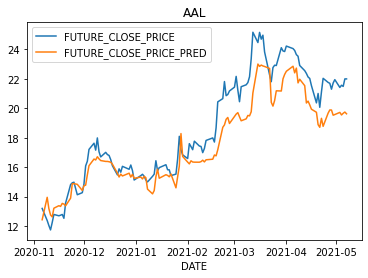

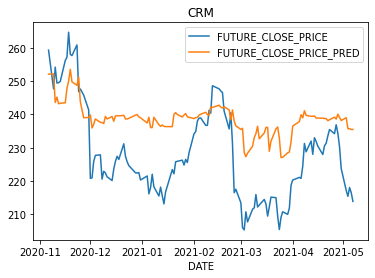

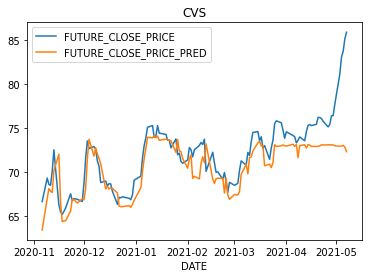

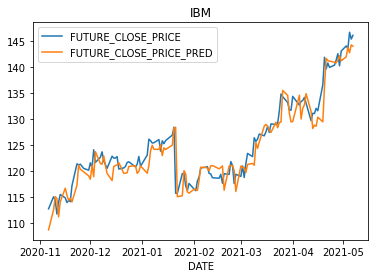

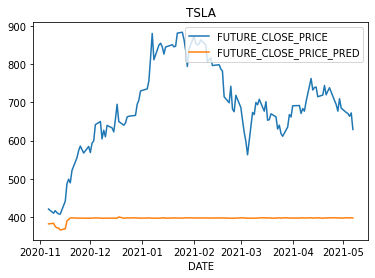

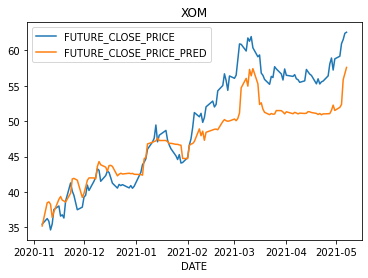

In [11]:



idadf = IdaDataFrame(idadb, 'stocks_features_test')
print(idadf.head())


code_str_host_spus = """def stocks_rf_ml(self, df):

    import numpy as np


    from sklearn.impute import SimpleImputer
    from sklearn.metrics import mean_squared_error
    from sklearn.ensemble import RandomForestRegressor
    from ibm_watson_machine_learning import APIClient



    imputed_df = df.copy()
    imputed_df.dropna(inplace=True)
    name = imputed_df.TICKER[0]
    #test = str(self.getDatasliceId())+'_'+str(self.getNumberOfSpus())+'_'+str(self.getNumberOfDataSlices())

    from sklearn.preprocessing import LabelEncoder

    temp_dict = dict()



    #imputed_df.dropna(inplace=True)


    columns = imputed_df.columns
    for column in columns:

        if column=='ID':
            continue

        #impute missing values 
        # mean for numerical and 'missing' for categorical
        if (imputed_df[column].dtype == 'float64' or imputed_df[column].dtype == 'int64'):
           if imputed_df[column].isnull().sum()==len(imputed_df):

                imputed_df[column] = imputed_df[column].fillna(0)


           else :

                imp = SimpleImputer(missing_values=np.nan, strategy='mean')

                transformed_column = imp.fit_transform(imputed_df[column].values.reshape(-1, 1))

                imputed_df[column] = transformed_column


        if (imputed_df[column].dtype == 'object'):
            # impute missing values for categorical variables


            imp = SimpleImputer(missing_values=None, strategy='constant', fill_value='missing')
            imputed_df[column] = imp.fit_transform(imputed_df[column].values.reshape(-1, 1))
            imputed_df[column] = imputed_df[column].astype('str')

            le = LabelEncoder()

            le.fit(imputed_df[column])
                    # print(le.classes_)
            imputed_df[column] = le.transform(imputed_df[column])
            temp_dict[column] = le

    wml_credentials = {
                   'url': 'https://us-south.ml.cloud.ibm.com',
                   'apikey':'xxx'
                  }

    client = APIClient(wml_credentials)
    client.set.default_space('xxx')
    model_dict= client.repository.get_model_details()

    
   

    rf=None


    for key, value in model_dict.items():

        if (key=='resources'):
            for res_element in value:
                metadata_dic = res_element.get('metadata')
                #print(metadata_dic)
                model_name ='rf_sklearn_wml_'+name
                if (metadata_dic.get('name')==model_name):
                   rf = client.repository.load(metadata_dic.get('id'))






    X_test = imputed_df.drop(['FUTURE_CLOSE_PRICE'], axis=1)
    y_test = imputed_df['FUTURE_CLOSE_PRICE']

    test_results_df = X_test.copy()

    y_pred = rf.predict(X_test)
    test_results_df['FUTURE_CLOSE_PRICE_PRED'] =y_pred
    test_results_df['FUTURE_CLOSE_PRICE'] =y_test



    accuracy  = rf.score(X_test, y_test)    


    rms = mean_squared_error(y_test, y_pred)

    ds_size = len(X_test)
    test_results_df['DATASET_SIZE'] = ds_size
    test_results_df['ACCURACY']=round(accuracy,2)
    test_results_df['MEAN_SQUARE_ERROR']=round(rms)


    #for all the columns that had label encoders, do an inverse transform

    original_columns = test_results_df.columns

    for column in original_columns:

     if column in temp_dict:   
      test_results_df[column] = temp_dict[column].inverse_transform(test_results_df[column])








    def print_output(x):
                row = [int(x['ID']), x['FUTURE_CLOSE_PRICE_PRED'], x['DATASET_SIZE'], x['ACCURACY']]


                self.output(row)


    test_results_df.apply(print_output, axis=1)



"""

output_signature = {'ID': 'int', 'FUTURE_CLOSE_PRICE_PRED': 'double',
                    'DATASET_SIZE': 'int', 'ACCURACY': 'float'}

import time

start = time.time()

nz_groupapply = NZFunGroupedApply(df=idadf, code_str=code_str_host_spus, index='TICKER', fun_name="stocks_rf_ml",
                                  output_signature=output_signature, merge_output_with_df=True)

result = nz_groupapply.get_result()
result = result.as_dataframe()
print("Host+ SPUs execution - slicing on user selection -ML function for partitions within slices\n")
print(result[['ID']])
print(result)
end = time.time()
print(end - start)

test_pred_groups = result.groupby('TICKER')

for name, group in test_pred_groups:
    input = group.copy()
    input["DATE"] = pd.to_datetime(input["DATE"])

    input = input.sort_values(by="DATE")
    input['DATE'] = input['DATE'].dt.date
    print(input)
    input.plot(x="DATE", y=["FUTURE_CLOSE_PRICE", "FUTURE_CLOSE_PRICE_PRED",], kind="line", title=name)
